### Preprocess all data from the anatomical session

MPRAGE slab:
1. Calculate warp of acq-slab_inv-1 -> acq_wb-inv-1 (in T1w-space), rigid registration. This is necessary to get the brain mask in slab-space (nighres mp2rage_skullstripping only works on whole-brain images). The inversions (either one) work better than the T1map or T1w image due to the white noise in the latter two
2. Create common template: make mean image, register to this image.

FLASH:
1. Register to MPRAGE-slab (rigid)

In T1w-space of the functional sessions, the brain mask can be used

## MPRAGE slab warp
Slab space -> T1w space

In [1]:
import nighres
from nighres.registration import embedded_antsreg, apply_coordinate_mappings
from nilearn import plotting
import numpy as np
import nibabel as nib

from glob import glob
import os

import matplotlib.pyplot as plt
%matplotlib inline

/home/stevenm/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
def apply_mask(img, mask):
    """ applies a simple mask to 3D Nifti image, assuming mask is binary [0., 1.]"""
    if isinstance(img, str):
        img = nib.load(img)
    if isinstance(mask, str):
        mask = nib.load(mask)
    img_dat = img.get_data()
    mask_dat = mask.get_data()
    img_dat[mask_dat==0.] = 0.
    
    return nib.Nifti1Image(img_dat, img.affine)

In [3]:
work_dir = './anat_session_tmp_files'
if not os.path.exists(work_dir):
    os.makedirs(work_dir)

In [ ]:
for sub in range(1, 19):
    print(sub)
    source_image = './data/raw/bids/sub-{sub}/ses-anat/anat/sub-{sub}_ses-anat_acq-slab_inv-1_MPRAGE.nii.gz'.format(**{'sub': str(sub).zfill(2)})
    # inv2 = './data/raw/bids/sub-{sub}/ses-anat/anat/sub-{sub}_ses-anat_acq-slab_inv-2_mprage.nii.gz'.format(**{'sub': str(sub).zfill(2)})
    # T1map = './data/raw/bids/sub-{sub}/ses-anat/anat/sub-{sub}_ses-anat_acq-slab_T1map.nii.gz'.format(**{'sub': str(sub).zfill(2)})
    # T1w = './data/raw/bids/sub-{sub}/ses-anat/anat/sub-{sub}_ses-anat_acq-slab_T1w.nii.gz'.format(**{'sub': str(sub).zfill(2)})

    # find corresponding inv-1 whole-brain image [note that this is the *preprocessed* image, ie skullstripped]
    target_image_brainmask = glob('./data/deriv/fmriprep/sub-{sub}/anat/sub-{sub}_desc-brain_mask.nii.gz'.format(**{'sub': str(sub).zfill(2)}))[0]
    if sub == 7:
        target_image = glob('./data/raw/bids/sub-{sub}/ses-*/anat/sub-{sub}_ses-*_inv-1_MPRAGE.nii'.format(**{'sub': str(sub).zfill(2)}))[1]
    else:
        target_image = glob('./data/raw/bids/sub-{sub}/ses-*/anat/sub-{sub}_ses-*_inv-1_MPRAGE.nii'.format(**{'sub': str(sub).zfill(2)}))[0]
    target_image_masked = apply_mask(target_image, target_image_brainmask)
    
    # need to save for nighres
    masked_img_fn = os.path.join(work_dir, 'sub-{sub}_acq-wb_inv-1_masked.nii.gz'.format(**{'sub': str(sub).zfill(2)}))
    nib.save(target_image_masked, masked_img_fn)
    warp_res = embedded_antsreg(source_image, masked_img_fn, run_rigid=True, run_affine=False, run_syn=False, 
                                save_data=True, output_dir=work_dir, overwrite=True)

1

Embedded ANTs Registration


/home/stevenm/miniconda3/lib/python3.7/site-packages/nipype/utils/misc.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterator
/home/stevenm/miniconda3/lib/python3.7/site-packages/duecredit/utils.py:32: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  and platform.linux_distribution()[0] == 'debian' \
/home/stevenm/miniconda3/lib/python3.7/site-packages/socks.py:58: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Callable
/home/stevenm/miniconda3/lib/python3.7/site-packages/nipype/interfaces/base/traits_extension.py:28: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections imp


Outputs will be saved to ./anat_session_tmp_files/

Saving ./anat_session_tmp_files/sub-01_ses-anat_acq-slab_inv-1_MPRAGE_tmp_srccoord.nii.gz

Saving ./anat_session_tmp_files/sub-01_ses-anat_acq-slab_inv-1_MPRAGE_tmp_trgcoord.nii.gz
registering ./data/raw/bids/sub-01/ses-anat/anat/sub-01_ses-anat_acq-slab_inv-1_MPRAGE.nii.gz
 to ./anat_session_tmp_files/sub-01_acq-wb_inv-1_masked.nii.gz
antsRegistration --collapse-output-transforms 1 --dimensionality 3 --initialize-transforms-per-stage 0 --interpolation Linear --output sub-01_ses-anat_acq-slab_inv-1_MPRAGE_tmp_syn --transform Rigid[ 0.1 ] --metric MI[ ./anat_session_tmp_files/sub-01_acq-wb_inv-1_masked.nii.gz, ./data/raw/bids/sub-01/ses-anat/anat/sub-01_ses-anat_acq-slab_inv-1_MPRAGE.nii.gz, 1, 32, Random, 0.3 ] --convergence [ 1000x1000x1000, 1e-06, 10 ] --smoothing-sigmas 3.0x2.0x1.0 --shrink-factors 4x2x1 --use-histogram-matching 0 --winsorize-image-intensities [ 0.001, 0.999 ]  --write-composite-transform 0

Saving ./anat_session_

In [66]:
def build_coordinate_mapping(source_image, target_image, h5_forward, h5_inverse, output_dir='./', file_name=None,
                             verbose=False, save_data=True):
    from nipype.interfaces.ants import ApplyTransforms
    import nibabel as nb
    from nighres.io import load_volume, save_volume
    from nighres.utils import _output_dir_4saving, _fname_4saving, _check_topology_lut_dir

    X=0
    Y=1
    Z=2
    T=3
    
    # load
    if verbose:
        print('Loading source & target...')
    source = load_volume(source_image)
    src_affine = source.affine
    src_header = source.header
    nsx = source.header.get_data_shape()[X]
    nsy = source.header.get_data_shape()[Y]
    nsz = source.header.get_data_shape()[Z]
    rsx = source.header.get_zooms()[X]
    rsy = source.header.get_zooms()[Y]
    rsz = source.header.get_zooms()[Z]

    target = load_volume(target_image)
    trg_affine = target.affine
    trg_header = target.header
    ntx = target.header.get_data_shape()[X]
    nty = target.header.get_data_shape()[Y]
    ntz = target.header.get_data_shape()[Z]
    rtx = target.header.get_zooms()[X]
    rty = target.header.get_zooms()[Y]
    rtz = target.header.get_zooms()[Z]
    
    if verbose:
        print('Building coordinate mappings...')
    # build coordinate mappings
    src_coord = np.zeros((nsx,nsy,nsz,3))
    trg_coord = np.zeros((ntx,nty,ntz,3))
    for x in range(nsx):
        for y in range(nsy):
            for z in range(nsz):
                src_coord[x,y,z,X] = x
                src_coord[x,y,z,Y] = y
                src_coord[x,y,z,Z] = z
    src_map = nb.Nifti1Image(src_coord, source.affine, source.header)
    src_map_file = os.path.join(output_dir, _fname_4saving(file_name=file_name,
                                                           rootfile=source_image,
                                                           suffix='tmp_srccoord'))
    save_volume(src_map_file, src_map)
    for x in range(ntx):
        for y in range(nty):
            for z in range(ntz):
                trg_coord[x,y,z,X] = x
                trg_coord[x,y,z,Y] = y
                trg_coord[x,y,z,Z] = z
    trg_map = nb.Nifti1Image(trg_coord, target.affine, target.header)
    trg_map_file = os.path.join(output_dir, _fname_4saving(file_name=file_name,
                                                           rootfile=source_image,
                                                           suffix='tmp_trgcoord'))
    save_volume(trg_map_file, trg_map)
    
    # Create coordinate mappings
    if verbose:
        print('Applying transforms to forward...')
    src_at = ApplyTransforms()
    src_at.inputs.dimension = 3
    src_at.inputs.input_image_type = 3
    src_at.inputs.input_image = src_map.get_filename()
    src_at.inputs.reference_image = target.get_filename()
    src_at.inputs.interpolation = 'Linear'
    src_at.inputs.transforms = h5_forward
#    src_at.inputs.invert_transform_flags = result.outputs.forward_invert_flags
    mapping = src_at.run()

    if verbose:
        print('Applying transforms to inverse...')
    trg_at = ApplyTransforms()
    trg_at.inputs.dimension = 3
    trg_at.inputs.input_image_type = 3
    trg_at.inputs.input_image = trg_map.get_filename()
    trg_at.inputs.reference_image = source.get_filename()
    trg_at.inputs.interpolation = 'Linear'
    trg_at.inputs.transforms = h5_inverse
#    trg_at.inputs.invert_transform_flags = result.outputs.reverse_invert_flags
    inverse = trg_at.run()
    
    # save - already done?
    if verbose:
        print('Creating niftis...')
    mapping_img = nb.Nifti1Image(nb.load(mapping.outputs.output_image).get_data(),
                                    target.affine, target.header)
    inverse_img = nb.Nifti1Image(nb.load(inverse.outputs.output_image).get_data(),
                                    source.affine, source.header)

    outputs = {'mapping': mapping_img,
               'inverse': inverse_img}

    if verbose:
        print('Clean-up & save...')
    # clean-up intermediate files
    os.remove(src_map_file)
    os.remove(trg_map_file)

    os.remove(mapping.outputs.output_image)
    os.remove(inverse.outputs.output_image)

    if save_data:
        mapping_file = os.path.join(output_dir,
                                    _fname_4saving(file_name=file_name,
                                               rootfile=source_image,
                                               suffix='ants-map'))

        inverse_mapping_file = os.path.join(output_dir,
                                            _fname_4saving(file_name=file_name,
                                                    rootfile=source_image,
                                                    suffix='ants-invmap'))
#         save_volume(transformed_source_file, transformed_img)
        save_volume(mapping_file, mapping_img)
        save_volume(inverse_mapping_file, inverse_img)
        
    return outputs

for sub in np.arange(1, 19):
    if sub == 12:
        continue
    
    sub_str = str(sub).zfill(2)
    print(sub_str)

    source_t1w = './data/deriv/fmriprep/sub-{}/anat/sub-{}_desc-preproc_T1w.nii.gz'.format(sub_str, sub_str)
    target_mni = './data/deriv/fmriprep/sub-{}/anat/sub-{}_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'.format(sub_str, sub_str)
    warp_t1w2mni = './data/deriv/fmriprep/sub-{}/anat/sub-{}_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5'.format(sub_str, sub_str)
    warp_mni2t1w = './data/deriv/fmriprep/sub-{}/anat/sub-{}_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5'.format(sub_str, sub_str)
    coord_maps = build_coordinate_mapping(source_t1w, 
                                          target_mni, 
                                          h5_forward=warp_t1w2mni, 
                                          h5_inverse=warp_mni2t1w, 
                                          verbose=True, save_data=False)
    forward_cmap_name = './data/deriv/fmriprep/sub-{}/anat/sub-{}_from-T1w_to-MNI152NLin2009cAsym_mode-forward_coordinate_mapping.nii.gz'.format(sub_str, sub_str)
    inverse_cmap_name = './data/deriv/fmriprep/sub-{}/anat/sub-{}_from-T1w_to-MNI152NLin2009cAsym_mode-inverse_coordinate_mapping.nii.gz'.format(sub_str, sub_str)
    
    nib.save(coord_maps['mapping'], forward_cmap_name)
    nib.save(coord_maps['inverse'], inverse_cmap_name)

01
Loading source & target...
Building coordinate mappings...

Saving ./sub-01_desc-preproc_T1w_tmp_srccoord.nii.gz

Saving ./sub-01_desc-preproc_T1w_tmp_trgcoord.nii.gz
Applying transforms to forward...
Applying transforms to inverse...
Creating niftis...
Clean-up & save...
02
Loading source & target...
Building coordinate mappings...

Saving ./sub-02_desc-preproc_T1w_tmp_srccoord.nii.gz

Saving ./sub-02_desc-preproc_T1w_tmp_trgcoord.nii.gz
Applying transforms to forward...
Applying transforms to inverse...
Creating niftis...
Clean-up & save...
03
Loading source & target...
Building coordinate mappings...

Saving ./sub-03_desc-preproc_T1w_tmp_srccoord.nii.gz

Saving ./sub-03_desc-preproc_T1w_tmp_trgcoord.nii.gz
Applying transforms to forward...
Applying transforms to inverse...
Creating niftis...
Clean-up & save...
04
Loading source & target...
Building coordinate mappings...

Saving ./sub-04_desc-preproc_T1w_tmp_srccoord.nii.gz

Saving ./sub-04_desc-preproc_T1w_tmp_trgcoord.nii.gz
Ap

### FLASH warp
Flash -> slab (rigid, masked)

In [69]:
for sub in np.arange(1,19):
    source_image = './data/raw/bids/sub-{sub}/ses-anat/anat/sub-{sub}_ses-anat_echo-{echo}_part-mag_FLASH.nii.gz'.format(**{'sub': str(sub).zfill(2), 'echo': 1})
    target_image = './data/raw/bids/sub-{sub}/ses-anat/anat/sub-{sub}_ses-anat_acq-slab_inv-1_MPRAGE.nii.gz'.format(**{'sub': str(sub).zfill(2)})
    brain_mask = glob('./data/deriv/fmriprep/sub-{sub}/anat/sub-{sub}_desc-brain_mask.nii.gz'.format(**{'sub': str(sub).zfill(2)}))[0]
    brain_mask_warp = './anat_session_tmp_files/sub-{sub}_ses-anat_acq-slab_inv-1_MPRAGE_ants-invmap.nii.gz'.format(**{'sub': str(sub).zfill(2)})

    # apply warp to brain mask
    brain_mask_warped = apply_coordinate_mappings(brain_mask, brain_mask_warp)['result']
    nib.save(brain_mask_warped, os.path.join(work_dir, 'sub-{sub}_space-slab_brainmask.nii.gz'.format(sub=str(sub).zfill(2))))

    # apply mask to target image
    target_image_masked = apply_mask(target_image, brain_mask_warped)
    target_image_masked_fn = os.path.join(work_dir, 'sub-{sub}_echo-1_part-mag_FLASH.nii.gz'.format(**{'sub': str(sub).zfill(2)}))
    nib.save(target_image_masked, target_image_masked_fn) # save is required for embedded_antsreg, as it needs a fn

    # register
    warp_res = embedded_antsreg(source_image, target_image_masked_fn, 
                                run_rigid=True, run_affine=False, run_syn=False, 
                                save_data=True, output_dir=work_dir)

    # apply warps to other echos
    for echo in [1,2,3]:
        source_fn = './data/raw/bids/sub-{sub}/ses-anat/anat/sub-{sub}_ses-anat_echo-{echo}_part-mag_FLASH.nii.gz'.format(**{'sub': str(sub).zfill(2), 'echo': echo})
        transformed_source = apply_coordinate_mappings(source_fn, warp_res['mapping'])['result']
        nib.save(transformed_source, os.path.join(work_dir, 'sub-{sub}_echo-{echo}_space-slab_part-mag_FLASH.nii.gz'.format(**{'sub': str(sub).zfill(2), 'echo': echo})))


Apply coordinate mappings

Embedded ANTs Registration

Outputs will be saved to ./anat_session_tmp_files/
skip computation (use existing results)

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Embedded ANTs Registration

Outputs will be saved to ./anat_session_tmp_files/
skip computation (use existing results)

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings

Embedded ANTs Registration

Outputs will be saved to ./anat_session_tmp_files/
skip computation (use existing results)

Apply coordinate mappings

Apply coordinate mappings

Apply coordinate mappings


KeyboardInterrupt: 

In [74]:
def combine_tedana(tes, data, combmode=None, mask=None, overwrite=False, verbose=False):
    """ Function based on tedana main workflow for fast combination of echos """
    from tedana import utils, model, io, decay, combine
    from scipy import stats
    import numpy as np
    import os
    
    # ensure tes are in appropriate format
    tes = [float(te) for te in tes]
    n_echos = len(tes)

    # coerce data to samples x echos x time array
    if isinstance(data, str):
        data = [data]

    if verbose:
        print('Starting to load data...', end='')
    catd, ref_img = io.load_data(data, n_echos=n_echos)
    n_samp, n_echos, n_vols = catd.shape
    if verbose:
        print('success')
    
    if verbose:
        print('Making adaptive mask...', end='')
    mask, masksum = utils.make_adaptive_mask(catd, mask=mask, minimum=False, getsum=True)
    if verbose:
        print('success')

    # check if the t2s-map is already created first
    base_name = data[0].replace('_echo-1', '_%s').replace('.nii', '').replace('.gz', '')
    if not os.path.exists(base_name %'t2sv' + '.nii.gz') or overwrite:
        if verbose:
            print('Fitting decay...', end='')
        t2s, s0, t2ss, s0s, t2sG, s0G, residuals_limited, residualss, residuals_full = decay.fit_decay(catd, tes, mask, masksum, return_residuals=True)
        if verbose:
            print('success')

            
        # set a hard cap for the T2* map
        # anything that is 10x higher than the 99.5 %ile will be reset to 99.5 %ile
        if verbose:
            print('Setting cap on t2star...', end='')
        cap_t2s = stats.scoreatpercentile(t2s.flatten(), 99.5,
                                          interpolation_method='lower')
        t2s[t2s > cap_t2s * 10] = cap_t2s
        if verbose:
            print('success')
        
        # save
        print('Starting saving...', end='')
        io.filewrite(t2s, base_name %'t2sv' + '.nii', ref_img, gzip=True)
        print('t2s done..', end='')
        io.filewrite(s0, base_name %'s0v' + '.nii', ref_img, gzip=True)
        print('s0v done..', end='')
        io.filewrite(t2ss, base_name %'t2ss' + '.nii', ref_img, gzip=True)
        print('t2ss done..', end='')
        io.filewrite(s0s, base_name %'s0vs' + '.nii', ref_img, gzip=True)
        print('s0vs done..', end='')
        io.filewrite(t2sG, base_name %'t2svG' + '.nii', ref_img, gzip=True)
        print('t2svG done..', end='')
        io.filewrite(s0G, base_name %'s0vG' + '.nii', ref_img, gzip=True)
        print('s0vG done..', end='')
        io.filewrite(residuals_limited, base_name %'residualsv' + '.nii', ref_img, gzip=True)
        print('residualsv done..', end='')
        io.filewrite(residualss, base_name %'residualss' + '.nii', ref_img, gzip=True)
        print('residualss done..', end='')
        io.filewrite(residuals_full, base_name %'residualsvG' + '.nii', ref_img, gzip=True)
        print('residualsvG done..', end='')
    else:
        t2sG = utils.load_image(base_name %'t2svG' + '.nii.gz')
        t2s = utils.load_image(base_name %'t2sv' + '.nii.gz')
    
    if combmode is not None:
        # optimally combine data
        if verbose:
            print('Starting combination...', end='')
        data_oc = combine.make_optcom(catd, tes, mask, t2s=t2sG, combmode=combmode)
        if combmode == 't2s':
            ext = 'optcomb'
        else:
            ext = 'PAID'
        print('Combined, writing results...')
    
        # make sure to set all nan-values/inf to 0
        data_oc[np.isinf(data_oc)] = 0
        data_oc[np.isnan(data_oc)] = 0
        io.filewrite(data_oc, base_name %ext + '.nii', ref_img, gzip=True)

In [78]:
# T2starmap
import json
tes = []
for echo in [1,2,3]:
    with open('./data/raw/bids/sub-01/ses-anat/anat/sub-01_ses-anat_echo-%d_part-mag_FLASH.json'%echo, 'r') as f:
        tes.append(json.load(f)['EchoTime'])

sub = 1
#echo_template = os.path.join(work_dir, 'sub-{sub}_echo-{echo}_space-slab_part-mag_FLASH.nii.gz')
echo_template = './data/raw/bids/sub-01/ses-anat/anat/sub-{sub}_ses-anat_echo-{echo}_part-mag_FLASH.nii.gz'

#mask_template = os.path.join(work_dir, 'sub-{sub}_space-slab_brainmask.nii.gz')

echos = [echo_template.format(**{'sub': str(sub).zfill(2), 'echo': echo}) for echo in [1,2,3]]
#mask = mask_template.format(sub=str(sub).zfill(2))
combine_tedana(tes, echos)#3, mask=mask)

/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Starting saving...t2s done..s0v done..t2ss done..s0vs done..t2svG done..s0vG done..residualsv done..residualss done..residualsvG done..

### Warp atlas to FLASH-space
This is a warp from MNI -> T1w -> T1w_slab -> FLASH

In [4]:
from utils import load_atlas
atlas = load_atlas(resolution='1mm')

In [5]:
def get_t1w2mni_warp(subject, kind='inverse'):
    return glob('./data/deriv/fmriprep/sub-{sub}/anat/sub-{sub}_from-T1w_to-MNI152NLin2009cAsym_mode-{kind}_coordinate_mapping.nii.gz'.format(**{'sub': str(subject).zfill(2), 'kind':kind}))[0]

def get_slab2t1w_warp(subject, kind='inverse'):
    if kind == 'inverse':
        kind_ = 'invmap'
    else:
        kind_ = 'map'        
    return glob('./anat_session_tmp_files/sub-{sub}_ses-anat_acq-slab_inv-1_MPRAGE_ants-{kind}.nii.gz'.format(**{'sub': str(subject).zfill(2), 'kind': kind_}))[0]

def get_flash2slab_warp(subject, kind='inverse'):
    if kind == 'inverse':
        kind_ = 'invmap'
    else:
        kind_ = 'map'
        
    return glob('./anat_session_tmp_files/sub-{sub}_ses-anat_echo-1_part-mag_FLASH_ants-{kind}.nii.gz'.format(**{'sub': str(subject).zfill(2), 'kind':kind_}))[0]

In [6]:
from sklearn.datasets.base import Bunch

def warp_atlas(atlas, **kwargs):
    labels = atlas.labels
    maps = atlas.maps
    
    atlas_warped = atlas.copy()
#    atlas_warped['maps'] = apply_coordinate_mappings(atlas.maps, **kwargs)['result']
    atlas_warped = Bunch(labels=list(atlas.labels), maps=apply_coordinate_mappings(atlas.maps, **kwargs)['result'])
    return atlas_warped

In [9]:
sub = 1
atlas_this_sub = warp_atlas(atlas, mapping1=get_t1w2mni_warp(sub), mapping2=get_slab2t1w_warp(sub), mapping3=get_flash2slab_warp(sub))


Apply coordinate mappings


/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/stevenm/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/stevenm/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: 

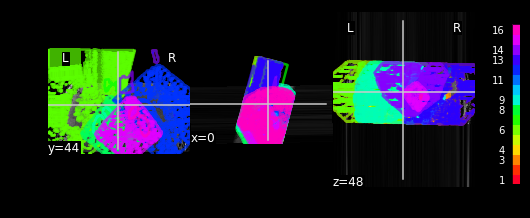

In [11]:
bg_img = './anat_session_tmp_files/sub-01_echo-1_space-slab_part-mag_FLASH.nii.gz'
plotting.plot_prob_atlas(atlas_this_sub.maps, bg_img=bg_img, view_type='contours', colorbar=True, threshold=0.3)

In [7]:
import nilearn
from nilearn import image

/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:600: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(axes, collections.Sequence):
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_l

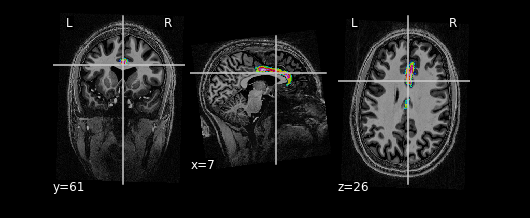

In [8]:
plotting.plot_roi(nilearn.image.index_img(atlas_this_sub_t1w.maps, 0), 
                  bg_img='./data/deriv/fmriprep/sub-01/anat/sub-01_desc-preproc_T1w.nii.gz')

In [70]:
!ls ./anat_session_tmp_files

sub-01_acq-wb_inv-1_masked.nii.gz
sub-01_echo-1_part-mag_FLASH.nii.gz
sub-01_echo-1_space-slab_part-mag_FLASH.nii.gz
sub-01_echo-2_space-slab_part-mag_FLASH.nii.gz
sub-01_echo-3_space-slab_part-mag_FLASH.nii.gz
sub-01_optcomb_space-slab_part-mag_FLASH.nii.gz
sub-01_residualss_space-slab_part-mag_FLASH.nii.gz
sub-01_residualsvG_space-slab_part-mag_FLASH.nii.gz
sub-01_residualsv_space-slab_part-mag_FLASH.nii.gz
sub-01_s0vG_space-slab_part-mag_FLASH.nii.gz
sub-01_s0v_space-slab_part-mag_FLASH.nii.gz
sub-01_s0vs_space-slab_part-mag_FLASH.nii.gz
sub-01_ses-anat_acq-slab_inv-1_MPRAGE_ants-def.nii.gz
sub-01_ses-anat_acq-slab_inv-1_MPRAGE_ants-invmap.nii.gz
sub-01_ses-anat_acq-slab_inv-1_MPRAGE_ants-map.nii.gz
sub-01_ses-anat_echo-1_part-mag_FLASH_ants-def.nii.gz
sub-01_ses-anat_echo-1_part-mag_FLASH_ants-invmap.nii.gz
sub-01_ses-anat_echo-1_part-mag_FLASH_ants-map.nii.gz
sub-01_space-slab_brainmask.nii.gz
sub-01_t2ss_space-slab_part-mag_FLASH.nii.gz
sub-01_t2svG_space-slab_part-mag_FLASH.nii.

In [ ]:
## load atlas, warp to this subject space


(array([1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.9400000e+02,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0649405e+07]),
 array([-1.19374312e+13, -1.07436881e+13, -9.54994499e+12, -8.35620186e+12,
        -7.16245874e+12, -5.96871562e+12, -4.77497249e+12, -3.58122937e+12,
        -2.38748625e+12, -1.19374312e+12,  2.18651489e+00]),
 <a list of 10 Patch objects>)

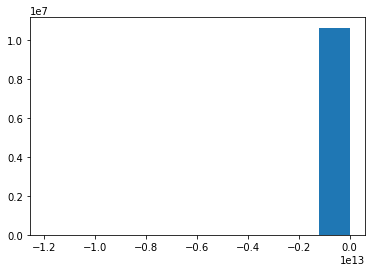

In [62]:
import matplotlib.pyplot as plt
plt.hist(nib.load('./anat_session_tmp_files/sub-01_t2sv_space-slab_part-mag_FLASH.nii.gz').get_data().ravel())

In [83]:
echos = [nib.load(echo_template.format(**{'sub': str(sub).zfill(2), 'echo': x})) for x in [1,2,3]]

In [87]:
from nilearn.image import concat_imgs
echos_4D = concat_imgs(echos)

In [99]:
selected_slice = echos_4D.get_data()[:,192,:,:]

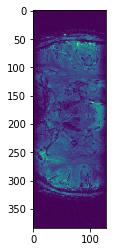

In [121]:
plt.imshow(selected_slice[:,:,2])

In [ ]:
selected_slice

In [126]:
selected_slice = selected_slice/selected_slice.max()

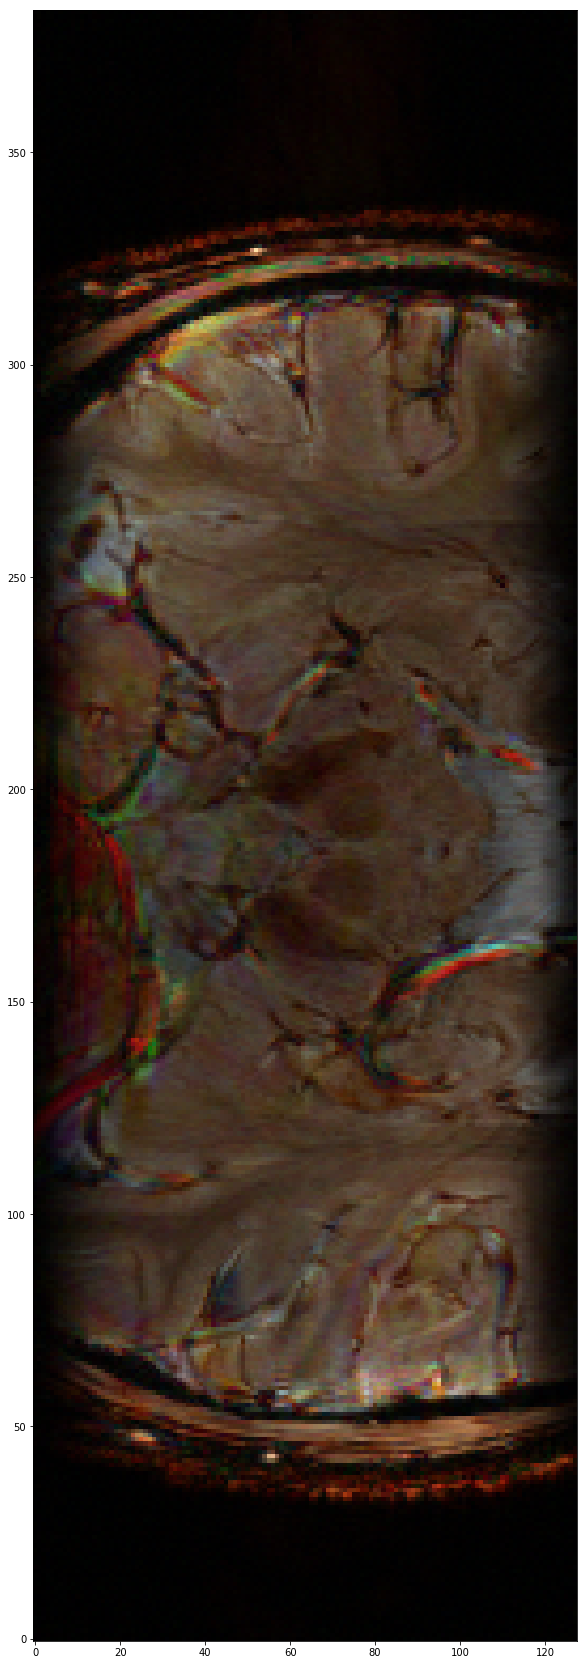

In [130]:
plt.imshow(selected_slice, origin='lower')
plt.gcf().set_size_inches(30, 30)


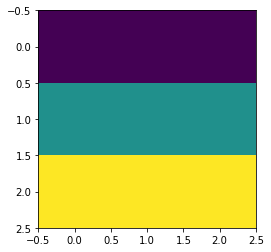

In [114]:
test_mat = np.array([np.ones(3), np.ones(3)*2, np.ones(3)*3])
test_mat.shape
plt.imshow(test_mat)

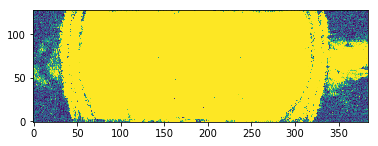

In [118]:
plt.imshow(echos[0].get_data()[:,192,:].T, origin='lower', vmax=100)

In [64]:
plotting.plot_anat('./data/raw/bids/sub-01/ses-anat/anat/sub-01')

[0.01122, 0.020390000000000002, 0.02957]

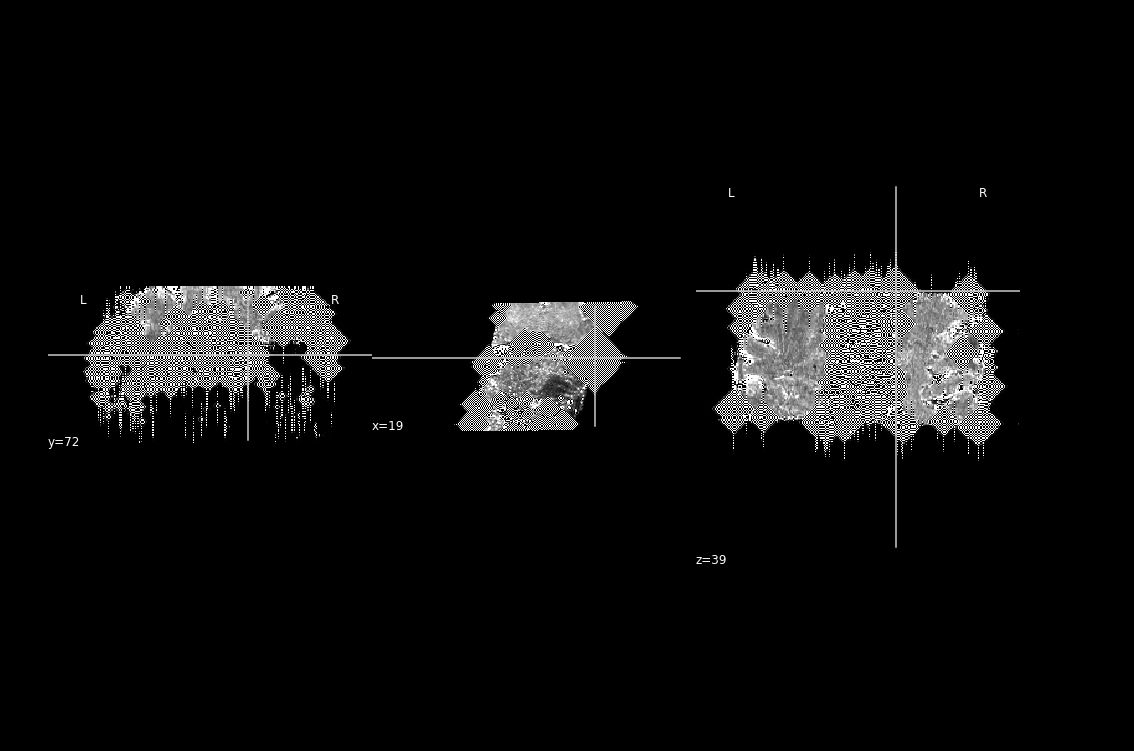

In [67]:
plotting.plot_anat('./anat_session_tmp_files/sub-01_t2svG_space-slab_part-mag_FLASH.nii.gz',
                   vmax=.05, vmin=0)

plt.gcf().set_size_inches(15,10)

In [31]:
warp_res

{'transformed_source': <nibabel.nifti1.Nifti1Image at 0x7f80d9e32f60>,
 'mapping': <nibabel.nifti1.Nifti1Image at 0x7f80d9e32fd0>,
 'inverse': <nibabel.nifti1.Nifti1Image at 0x7f80d9e32e10>}

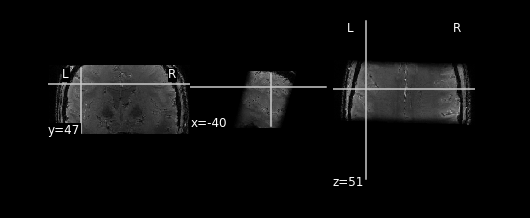

In [32]:
plotting.plot_anat(warp_res['transformed_source'])

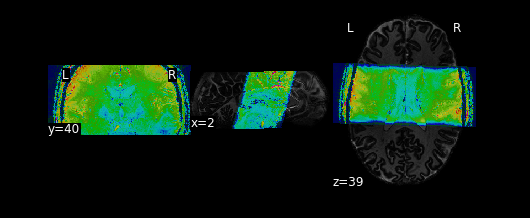

In [34]:
plotting.plot_roi(warp_res['transformed_source'], bg_img=target_image_masked, draw_cross=False)

In [55]:
# for sub in range(1, 19):
#     source_image = './data/raw/bids/sub-{sub}/ses-anat/anat/sub-{sub}_ses-anat_acq-slab_inv-1_MPRAGE.nii.gz'.format(**{'sub': str(sub).zfill(2)})
#     # inv2 = './data/raw/bids/sub-{sub}/ses-anat/anat/sub-{sub}_ses-anat_acq-slab_inv-2_mprage.nii.gz'.format(**{'sub': str(sub).zfill(2)})
#     # T1map = './data/raw/bids/sub-{sub}/ses-anat/anat/sub-{sub}_ses-anat_acq-slab_T1map.nii.gz'.format(**{'sub': str(sub).zfill(2)})
#     # T1w = './data/raw/bids/sub-{sub}/ses-anat/anat/sub-{sub}_ses-anat_acq-slab_T1w.nii.gz'.format(**{'sub': str(sub).zfill(2)})

#     # find corresponding inv-1 whole-brain image [note that this is the *preprocessed* image, ie skullstripped]
#     target_image_brainmask = glob('./data/deriv/fmriprep/sub-{sub}/anat/sub-{sub}_T1w_brainmask.nii.gz'.format(**{'sub': str(sub).zfill(2)}))[0]
#     target_image = glob('./data/raw/bids/sub-{sub}/ses-*/anat/sub-{sub}_ses-*_inv-1_MPRAGE.nii'.format(**{'sub': str(sub).zfill(2)}))[0]
#     target_image_masked = apply_mask(target_image, target_image_brainmask)
    
#     # need to save for nighres
#     masked_img_fn = os.path.join(work_dir, 'sub-{sub}_acq-wb_inv-1_masked.nii.gz'.format(**{'sub': str(sub).zfill(2)}))
#     nib.save(target_image_masked, masked_img_fn)
#     warp_res = embedded_antsreg(source_image, masked_img_fn, run_rigid=True, run_affine=False, run_syn=False, 
#                                 save_data=True, output_dir=work_dir)


Embedded ANTs Registration

Outputs will be saved to ./data/raw/bids/sub-01/ses-anat/anat/

Saving ./data/raw/bids/sub-01/ses-anat/anat/sub-01_ses-anat_acq-slab_inv-1_MPRAGE_tmp_srccoord.nii.gz

Saving ./data/raw/bids/sub-01/ses-anat/anat/sub-01_ses-anat_acq-slab_inv-1_MPRAGE_tmp_trgcoord.nii.gz
registering ./data/raw/bids/sub-01/ses-anat/anat/sub-01_ses-anat_acq-slab_inv-1_MPRAGE.nii.gz
 to ./tmp.nii.gz
antsRegistration --collapse-output-transforms 1 --dimensionality 3 --initialize-transforms-per-stage 0 --interpolation Linear --output sub-01_ses-anat_acq-slab_inv-1_MPRAGE_tmp_syn --transform Rigid[ 0.1 ] --metric MI[ ./tmp.nii.gz, ./data/raw/bids/sub-01/ses-anat/anat/sub-01_ses-anat_acq-slab_inv-1_MPRAGE.nii.gz, 1, 32, Random, 0.3 ] --convergence [ 1000x1000x1000, 1e-06, 10 ] --smoothing-sigmas 3.0x2.0x1.0 --shrink-factors 4x2x1 --use-histogram-matching 0 --winsorize-image-intensities [ 0.001, 0.999 ]  --write-composite-transform 0


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


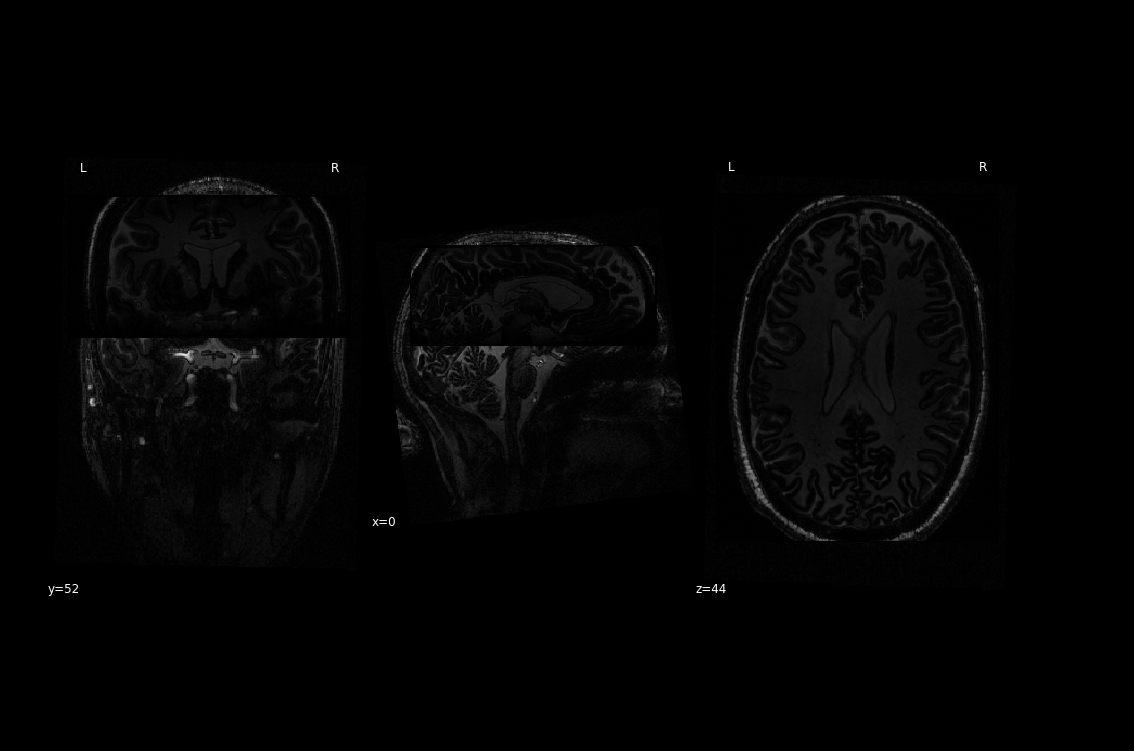

In [57]:
plotting.plot_anat(source_image, bg_img=target_image_masked, draw_cross=False)
plt.gcf().set_size_inches(15,10)

/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


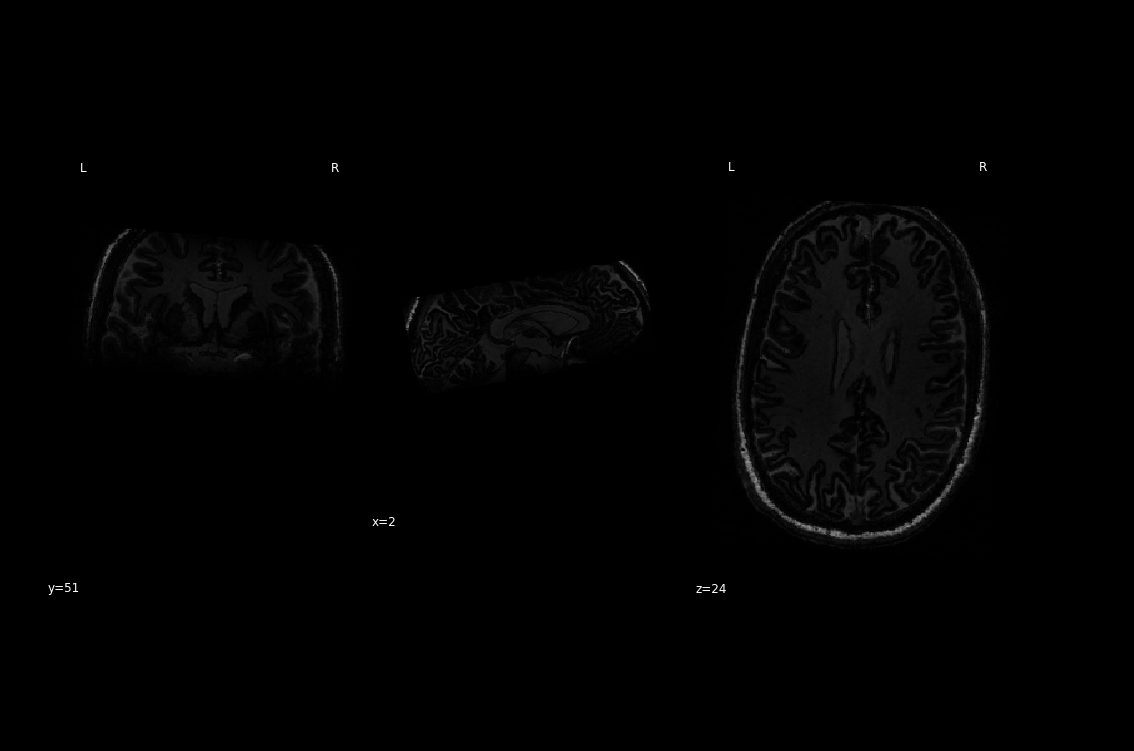

In [58]:
plotting.plot_anat(warp_res['transformed_source'], bg_img=target_image_masked, draw_cross=False)
plt.gcf().set_size_inches(15,10)

In [60]:
nib.save(warp_res['transformed_source'], 'tmp_transformed.nii.gz')

In [62]:
### better approach: make a common template of all pps, and only register that (if necessary)
# still need the warp to get the brain masked mprage images